In [ ]:
!pip install --upgrade pip

!pip install pyLDAvis

In [ ]:
!pip install pyLDAvis
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!apt-get update

! pip install konlpy
!pip install ujson
! pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Data Preprocessing Package
import re                       #정규식
import numpy as np
import pandas as pd
import os                      #디렉토리와 경로정보

# NLP Package
from konlpy.tag import * 
import gensim                    #토픽모델링을 하는 라이브러리
import gensim.corpora as corpora #텍스트분석
from gensim.models import CoherenceModel
from collections import Counter
import nltk

# # Visualization Package   

import pyLDAvis 
import pyLDAvis.gensim_models 
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
from matplotlib import font_manager
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
plt.rc('font', family='NanumBarunGothic')

from PIL import Image
plt.rcParams['font.family'] = 'NanumGothic'
mpl.matplotlib_fname()
%config InlineBackend.figure_format = 'retina'
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
from pprint import pprint #pretty print
import itertools #iterable 객체 처리
import math

import logging #로그처리
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings #경고 무시
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_rows', 200)

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [ ]:
# 기본 저장 주소
ROOT_PATH ="/content/drive/MyDrive"
# 데이터 저장 주소(low)
                 
DATA_STOP_WORD_FILE_NAME = os.path.join(ROOT_PATH + '/stopword.txt')   # 불용어 사전 

# 모델 저장 주소

LDA_MODEL_SAVE_NAME = os.path.join(ROOT_PATH+ "/Model_lda_topic_modeling.lda")
OPT_MODEL_SAVE_NAME = os.path.join(ROOT_PATH+ "/Model_opt_topic_modeling.lda")

# # 결과물 저장 주소

RESULT_SAVE_LDAVIS = os.path.join(ROOT_PATH+ "ABC_BERT/result/Result_lda_vis.html")
RESULT_TOPIC_EXCEL = os.path.join(ROOT_PATH +"ABC_BERT/result/Result_topic_excel.xlsx")
RESULT_corpus_EXCEL = os.path.join(ROOT_PATH +"ABC_BERT/result/Result_corpus_excel.xlsx")



> # 데이터 불러오기



In [ ]:
# 데이터 불러오기 
df = pd.read_csv("/content/drive/MyDrive/total_abc_reviews.csv") 
print(len(df))
# # 불러온 데이터의 값이 비어 있는지 확인
print('Null값이 있는지 확인합니다.',df.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')

print('중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다.', df.isnull().values.any()) # Null 값이 존재하는지 확인 (False=정상)
print('')


509
Null값이 있는지 확인합니다. False

중복 및, NULL값을 제거한 후, 다시 NULL값을 확인 합니다. False



In [ ]:
df

,Unnamed: 0,USER,DATE,STAR,LIKE,TITLE,REVIEW
0,0,dddd.d,2023-02-06 18:35:42-07:00,1,0,개느림 진짜 미치게느림,처음에 내 폰이 문젠줄알고 개당황했는데 앱자체가 미치게느려서 그냥 아무것도 할수가없...
1,1,ㄴㅇㅏ,2023-02-01 20:13:29-07:00,1,0,쿠폰을 줘도 못씀,쿠폰 준다고 앱 깔아서 카카오톡 친구 추가까지 했는데 일부 상품 제외라면서 할인 안...
2,2,LeoL🦁🦁,2023-01-20 17:12:46-07:00,1,0,ㄱㅂㅅ,진짜 최악이네요 주문한 상품의 결제가 어느순간 보니 취소되어있지 않나 고객센터는 전...
3,3,엑릭릭릭,2023-01-14 23:03:18-07:00,1,0,별점도 아까운 어플임,ABC마트가 망한다면 90%는 이 어플때문임\n반응속도부터 물건 찾는것도 ㅈㄹ 같고...
4,4,".,?..ㄷ",2023-01-11 17:45:23-07:00,1,0,최악의 쓰레기 어플,그냥 속도만 보면 답답해서 회원탈퇴하고싶게 만드는 앱\n걍 탈퇴함
...,...,...,...,...,...,...,...
504,4,옹옹옹오오,2020-03-08 18:11:07-07:00,1,0,앱 왜 만드신건가요..,로그인하면 오류 뜨고.. 웹기반이면 어플 없애고 웹으로만 하세요...
505,5,심시티의 어느심,2020-02-23 02:23:01-07:00,1,0,어플 개판이네,반응속도도 구리고 사이즈도 안뜨고 쿠폰 적용상품인데 쿠폰적용도안됨
506,6,얌채ㅋ,2020-02-21 01:49:03-07:00,1,0,어플좀 신경 써서 만드세요,인터페이스가 별로고 반응속도도 느려서 영 못쓰겠네요 그리고 검색해서 품목들 나오는데...
507,7,작살나리,2020-02-20 16:39:58-07:00,5,0,역시 실망안시킴 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ,거리멀어서 매장못가는게 아쉬운\n제주도거주자 1인...


In [ ]:
#별점 type변환
df.STAR = df.STAR.astype(float)
#별점 나누기
tmp_low=df[df['STAR']<=3]
tmp_low.to_csv('ABC_review_low')

tmp_high=df[df['STAR']>3]
tmp_high.to_csv('ABC_review_high')



> # 토크나이징(Tokenizing)



In [ ]:
tmp_high = tmp_high.reset_index().drop(columns = ["index", "Unnamed: 0"])

In [ ]:
tokenizer = Twitter() # 토큰나이저 지정
stopword_vocab = DATA_STOP_WORD_FILE_NAME # 불용어 파일 불러오기
sep = "\n" # 불용어 처리 인자

def build_vocab(data_frame,stopword_vocab, separate):
    
    # 불용어 데이터를 가져와 리스트로 변환합니다.
    with open(stopword_vocab, encoding = 'utf-8') as f:
        temp1 = []
        for i in f:
            temp1.append(i)
            
    globals()['stopword_vocab'] = []
    
    # 불용어 데이터는 전역변수 stopword_vocab 선언합니다. 
    # 구분자에 따라 stopword_vocab에 추가하여 불용어 사전을 구축합니다.
    for j in range(len(temp1)):
        temp2 = temp1[j].rstrip(separate)
        globals()['stopword_vocab'].append(temp2)
    
    #품사를 달고 token을 출력합니다.
    globals()['list_sent2words'] =[]
    for i in range(len(data_frame)) :
        num_list=[]
        temp = tokenizer.pos(data_frame[i])
        for j in range(len(temp)):
            num_list.append(temp[j])
        globals()['list_sent2words'].append(num_list)

    return [[word for word in doc if word not in globals()['stopword_vocab']] for doc in globals()['list_sent2words']]

result_data =build_vocab(tmp_high['REVIEW'],stopword_vocab, sep)

In [ ]:
#얻은 토큰에서 명사, 형용사,동사만 가져오기
newL=[]
N_POS = ['Noun']  
V_POS = ['Adjective'] 
V_POS1 = ["Verb"] 
for n in range(len(result_data)):
    temp = []
    for k in result_data[n]:
        if k[1] in V_POS:
            temp.append(k[0])
        elif k[1] in N_POS:
            temp.append(k[0])
        elif k[1] in V_POS1 :
            temp.append(k[0])
    newL.append(temp)
print(newL)

[[], [], ['우편번호', '검색', '안되네'], ['아주', '개', '병맛', '어플', '임', '어떻게', '된게', '핸드폰', '웹페이지', '더', '빨라', '어플', '무한', '로딩', '화면', '정지', '어플', '쓰겠냐'], [], ['살면서', '이', '따위', '엉망', '진창', '앱', '처음', '본다'], ['사이트', '느리고', '앱', '느리면', '어쩌', '자는거', '일', '드럽게', '하니까', '망하는거에요', '밖', '매장', '봐도', '토나올것', '같아요', '화', '딱지', '나서', '그냥', '다른데', '가서', '사고말지', '드럽고', '괘씸해서'], ['어플', '수준', '얼마나', '높은지', '데이터', '와이파이', '커도', '인지', '못', '하는', '수준', '요', '잘', '만들었다'], ['점', '낮으면', '안보', '일부러', '높게', '드령', '최악', '입니다', '덕분', '카드', '비번', '재', '설정', '했어요'], ['알림', '푸', '쉬', '설정', '멈춤', '나', '런가', '개', '쓰레기', '같네', '어플'], ['진짜', '구더기', '그', '자체', '신기하네용', '이', '정도', '수준', '앱', '있다니'], ['이렇게나', '시스템', '구린데', '어플', '이용', '시', '만원', '쿠폰', '주겠다는', '말', '무슨', '낯짝', '걸어놓으신', '거', '용', '어플', '사용', '쿠폰', '누를', '때', '앱스토어', '오지', '연결', '돼서', '연결', '된', '김', '리뷰', '드릴', '용', '속도', '개느', '리', '툭하면', '오류로', '대고', '있는', '이', '어플', '쓰라고', '만든', '건지', '의심', '되니까', '어서', '돈', '써서', '속도', '발', '맞춰가주세용', '개불', '편해요'], ['제', '써', '본

In [ ]:
#불용어 제거
def remove_stopwords(text):
    temp2 = []
    for j in range(len(text)) : 
        meaningful_words = [w for w in text[j] if not w in stopword_vocab]
        temp2.append(meaningful_words)
    return temp2

finalL=remove_stopwords(newL)

#길이가 1이상인 단어만 가져오기
num_list = []
for j in range(len(finalL)):
    temp = []
    for k in range(len(finalL[j])):
        if len(finalL[j][k]) > 1:
            temp.append(finalL[j][k])
    num_list.append(temp)

print(num_list)

[[], [], ['우편번호', '검색', '안되네'], ['아주', '병맛', '어플', '된게', '핸드폰', '웹페이지', '빨라', '어플', '무한', '로딩', '화면', '정지', '어플', '쓰겠냐'], [], ['살면서', '엉망', '진창', '처음', '본다'], ['사이트', '느리고', '느리면', '어쩌', '자는거', '드럽게', '하니까', '망하는거에요', '매장', '봐도', '토나올것', '같아요', '딱지', '나서', '그냥', '다른데', '가서', '사고말지', '드럽고', '괘씸해서'], ['어플', '수준', '높은지', '데이터', '와이파이', '커도', '인지', '하는', '수준', '만들었다'], ['낮으면', '안보', '일부러', '높게', '드령', '최악', '입니다', '덕분', '카드', '비번', '설정'], ['알림', '설정', '멈춤', '런가', '쓰레기', '같네', '어플'], ['진짜', '구더기', '자체', '신기하네용', '정도', '수준', '있다니'], ['이렇게나', '시스템', '구린데', '어플', '이용', '만원', '쿠폰', '주겠다는', '낯짝', '걸어놓으신', '어플', '사용', '쿠폰', '누를', '앱스토어', '오지', '연결', '돼서', '연결', '리뷰', '드릴', '속도', '개느', '툭하면', '오류로', '대고', '있는', '어플', '쓰라고', '만든', '건지', '의심', '되니까', '어서', '써서', '속도', '맞춰가주세용', '개불', '편해요'], ['제일', '느린거', '같아요', '신발', '쇼핑', '하러', '접속', '했다가', '구매', '의욕', '상실', '시키는', '답답한', '속도', '감탄', '합니다', '누르면', '실행', '안되고', '로딩', '걸리네요', '그냥', '매장', '가서', '사든', '사야겠어요'], ['들어가지지도', '않고', '와이파이', '데이터', '둘다', '안

In [ ]:
#추가 불용어제거
stopword = ['같아요','나서','된게','없애고','스팟','품목','하세요','이따','할수','건지','해도','해서','하면','신발','매장','마트','제주도','어플','젠줄알','자체','라면','마셈','있는','때문','같고','진짜','사나','있습니까','라라','하라','대한','계속','통합','그냥','다시','제대로','제발']
LL=[]
for j in range(len(num_list)):
    temp = [i for i in num_list[j] if i not in stopword]
    LL.append(temp)
print(LL)

[[], [], ['우편번호', '검색', '안되네'], ['아주', '병맛', '핸드폰', '웹페이지', '빨라', '무한', '로딩', '화면', '정지', '쓰겠냐'], [], ['살면서', '엉망', '진창', '처음', '본다'], ['사이트', '느리고', '느리면', '어쩌', '자는거', '드럽게', '하니까', '망하는거에요', '봐도', '토나올것', '딱지', '다른데', '가서', '사고말지', '드럽고', '괘씸해서'], ['수준', '높은지', '데이터', '와이파이', '커도', '인지', '하는', '수준', '만들었다'], ['낮으면', '안보', '일부러', '높게', '드령', '최악', '입니다', '덕분', '카드', '비번', '설정'], ['알림', '설정', '멈춤', '런가', '쓰레기', '같네'], ['구더기', '신기하네용', '정도', '수준', '있다니'], ['이렇게나', '시스템', '구린데', '이용', '만원', '쿠폰', '주겠다는', '낯짝', '걸어놓으신', '사용', '쿠폰', '누를', '앱스토어', '오지', '연결', '돼서', '연결', '리뷰', '드릴', '속도', '개느', '툭하면', '오류로', '대고', '쓰라고', '만든', '의심', '되니까', '어서', '써서', '속도', '맞춰가주세용', '개불', '편해요'], ['제일', '느린거', '쇼핑', '하러', '접속', '했다가', '구매', '의욕', '상실', '시키는', '답답한', '속도', '감탄', '합니다', '누르면', '실행', '안되고', '로딩', '걸리네요', '가서', '사든', '사야겠어요'], ['들어가지지도', '않고', '와이파이', '데이터', '둘다', '안되네요', '쓰레기', '놀랍다'], ['처음', '리뷰', '남깁니다', '정말', '처음', '입니다', '속도', '편의', '디자인', '안정', '수준', '미달', '입니다', '정도', '수준', '미달', '안해',

In [ ]:
# 전체 에 대한 워드 카운트 계수 확인

def word_corpus(result_data):
    #전체 단어의 갯수 파악
    words = list(itertools.chain(*result_data))
    print('전체 워드의 개수 : {}'.format(len(words)))

    #단어의 빈도수를 확인 후 추가할 불용어 확인 작업
    vocab = Counter(words)
    vocab_size = len(words)
    vocab = vocab.most_common(vocab_size) # 등장 빈도수가 높은 상위 n개의 단어만 저장 vocab
    return vocab

vocab=word_corpus(LL)
print(vocab)
# 전체 워드의 빈도 계수 
df_corpus=pd.DataFrame(columns=["text","count"])
tmp_list=[]
tmp_list1=[]
for word, num in vocab:
    tmp_list.append(word)
    tmp_list1.append(num)
df_corpus['text']=tmp_list
df_corpus['count']=tmp_list1
#상위 20개의 워드 카운드 계수만 출력
a=df_corpus.head(1000)
print(df_corpus.head(20))

#빈도분석한 결과를 별도의 파일에 저장함
a.to_excel(RESULT_corpus_EXCEL ,sheet_name = "sheet2low")


전체 워드의 개수 : 1140
[('좋아요', 14), ('구매', 13), ('쓰레기', 12), ('상품', 12), ('쿠폰', 9), ('속도', 8), ('한번', 8), ('있어서', 8), ('보기', 8), ('사이트', 7), ('수준', 7), ('이용', 7), ('사용', 7), ('입니다', 6), ('디자인', 6), ('개선', 6), ('오류', 6), ('편리하고', 6), ('좋은', 6), ('하기', 6), ('로딩', 5), ('처음', 5), ('정말', 5), ('완전', 5), ('결제', 5), ('로그인', 5), ('서버', 5), ('편하게', 5), ('기존', 5), ('룰렛', 5), ('되어서', 5), ('좋습니다', 5), ('느리고', 4), ('정도', 4), ('연결', 4), ('리뷰', 4), ('되니까', 4), ('쇼핑', 4), ('합니다', 4), ('누르면', 4), ('보이', 4), ('부분', 4), ('되서', 4), ('이벤트', 4), ('할인', 4), ('검색', 3), ('핸드폰', 3), ('엉망', 3), ('가서', 3), ('데이터', 3), ('와이파이', 3), ('하는', 3), ('낮으면', 3), ('만든', 3), ('편해요', 3), ('접속', 3), ('안되고', 3), ('절대', 3), ('후기', 3), ('사람', 3), ('모바일', 3), ('지금', 3), ('삭제', 3), ('하려고', 3), ('가기', 3), ('최고', 3), ('요즘', 3), ('골라', 3), ('선착순', 3), ('터지고', 3), ('가입', 3), ('적용', 3), ('사진', 3), ('되어', 3), ('자주', 3), ('전보', 3), ('찾기', 3), ('있어', 3), ('좋네요', 3), ('무한', 2), ('화면', 2), ('최악', 2), ('덕분', 2), ('설정', 2), ('이렇게나', 2), ('시스템', 2),



> # 단어 빈도수 시각화




In [ ]:
#한 리스트에 담아주기
title = []
for n in range(len(LL)):
    for word in LL[n] :
        title.append(word)
title

['우편번호',
 '검색',
 '안되네',
 '아주',
 '병맛',
 '핸드폰',
 '웹페이지',
 '빨라',
 '무한',
 '로딩',
 '화면',
 '정지',
 '쓰겠냐',
 '살면서',
 '엉망',
 '진창',
 '처음',
 '본다',
 '사이트',
 '느리고',
 '느리면',
 '어쩌',
 '자는거',
 '드럽게',
 '하니까',
 '망하는거에요',
 '봐도',
 '토나올것',
 '딱지',
 '다른데',
 '가서',
 '사고말지',
 '드럽고',
 '괘씸해서',
 '수준',
 '높은지',
 '데이터',
 '와이파이',
 '커도',
 '인지',
 '하는',
 '수준',
 '만들었다',
 '낮으면',
 '안보',
 '일부러',
 '높게',
 '드령',
 '최악',
 '입니다',
 '덕분',
 '카드',
 '비번',
 '설정',
 '알림',
 '설정',
 '멈춤',
 '런가',
 '쓰레기',
 '같네',
 '구더기',
 '신기하네용',
 '정도',
 '수준',
 '있다니',
 '이렇게나',
 '시스템',
 '구린데',
 '이용',
 '만원',
 '쿠폰',
 '주겠다는',
 '낯짝',
 '걸어놓으신',
 '사용',
 '쿠폰',
 '누를',
 '앱스토어',
 '오지',
 '연결',
 '돼서',
 '연결',
 '리뷰',
 '드릴',
 '속도',
 '개느',
 '툭하면',
 '오류로',
 '대고',
 '쓰라고',
 '만든',
 '의심',
 '되니까',
 '어서',
 '써서',
 '속도',
 '맞춰가주세용',
 '개불',
 '편해요',
 '제일',
 '느린거',
 '쇼핑',
 '하러',
 '접속',
 '했다가',
 '구매',
 '의욕',
 '상실',
 '시키는',
 '답답한',
 '속도',
 '감탄',
 '합니다',
 '누르면',
 '실행',
 '안되고',
 '로딩',
 '걸리네요',
 '가서',
 '사든',
 '사야겠어요',
 '들어가지지도',
 '않고',
 '와이파이',
 '데이터',
 '둘다',
 '안되네요',
 '쓰레기',
 '놀랍다',
 '처음',
 '리뷰',

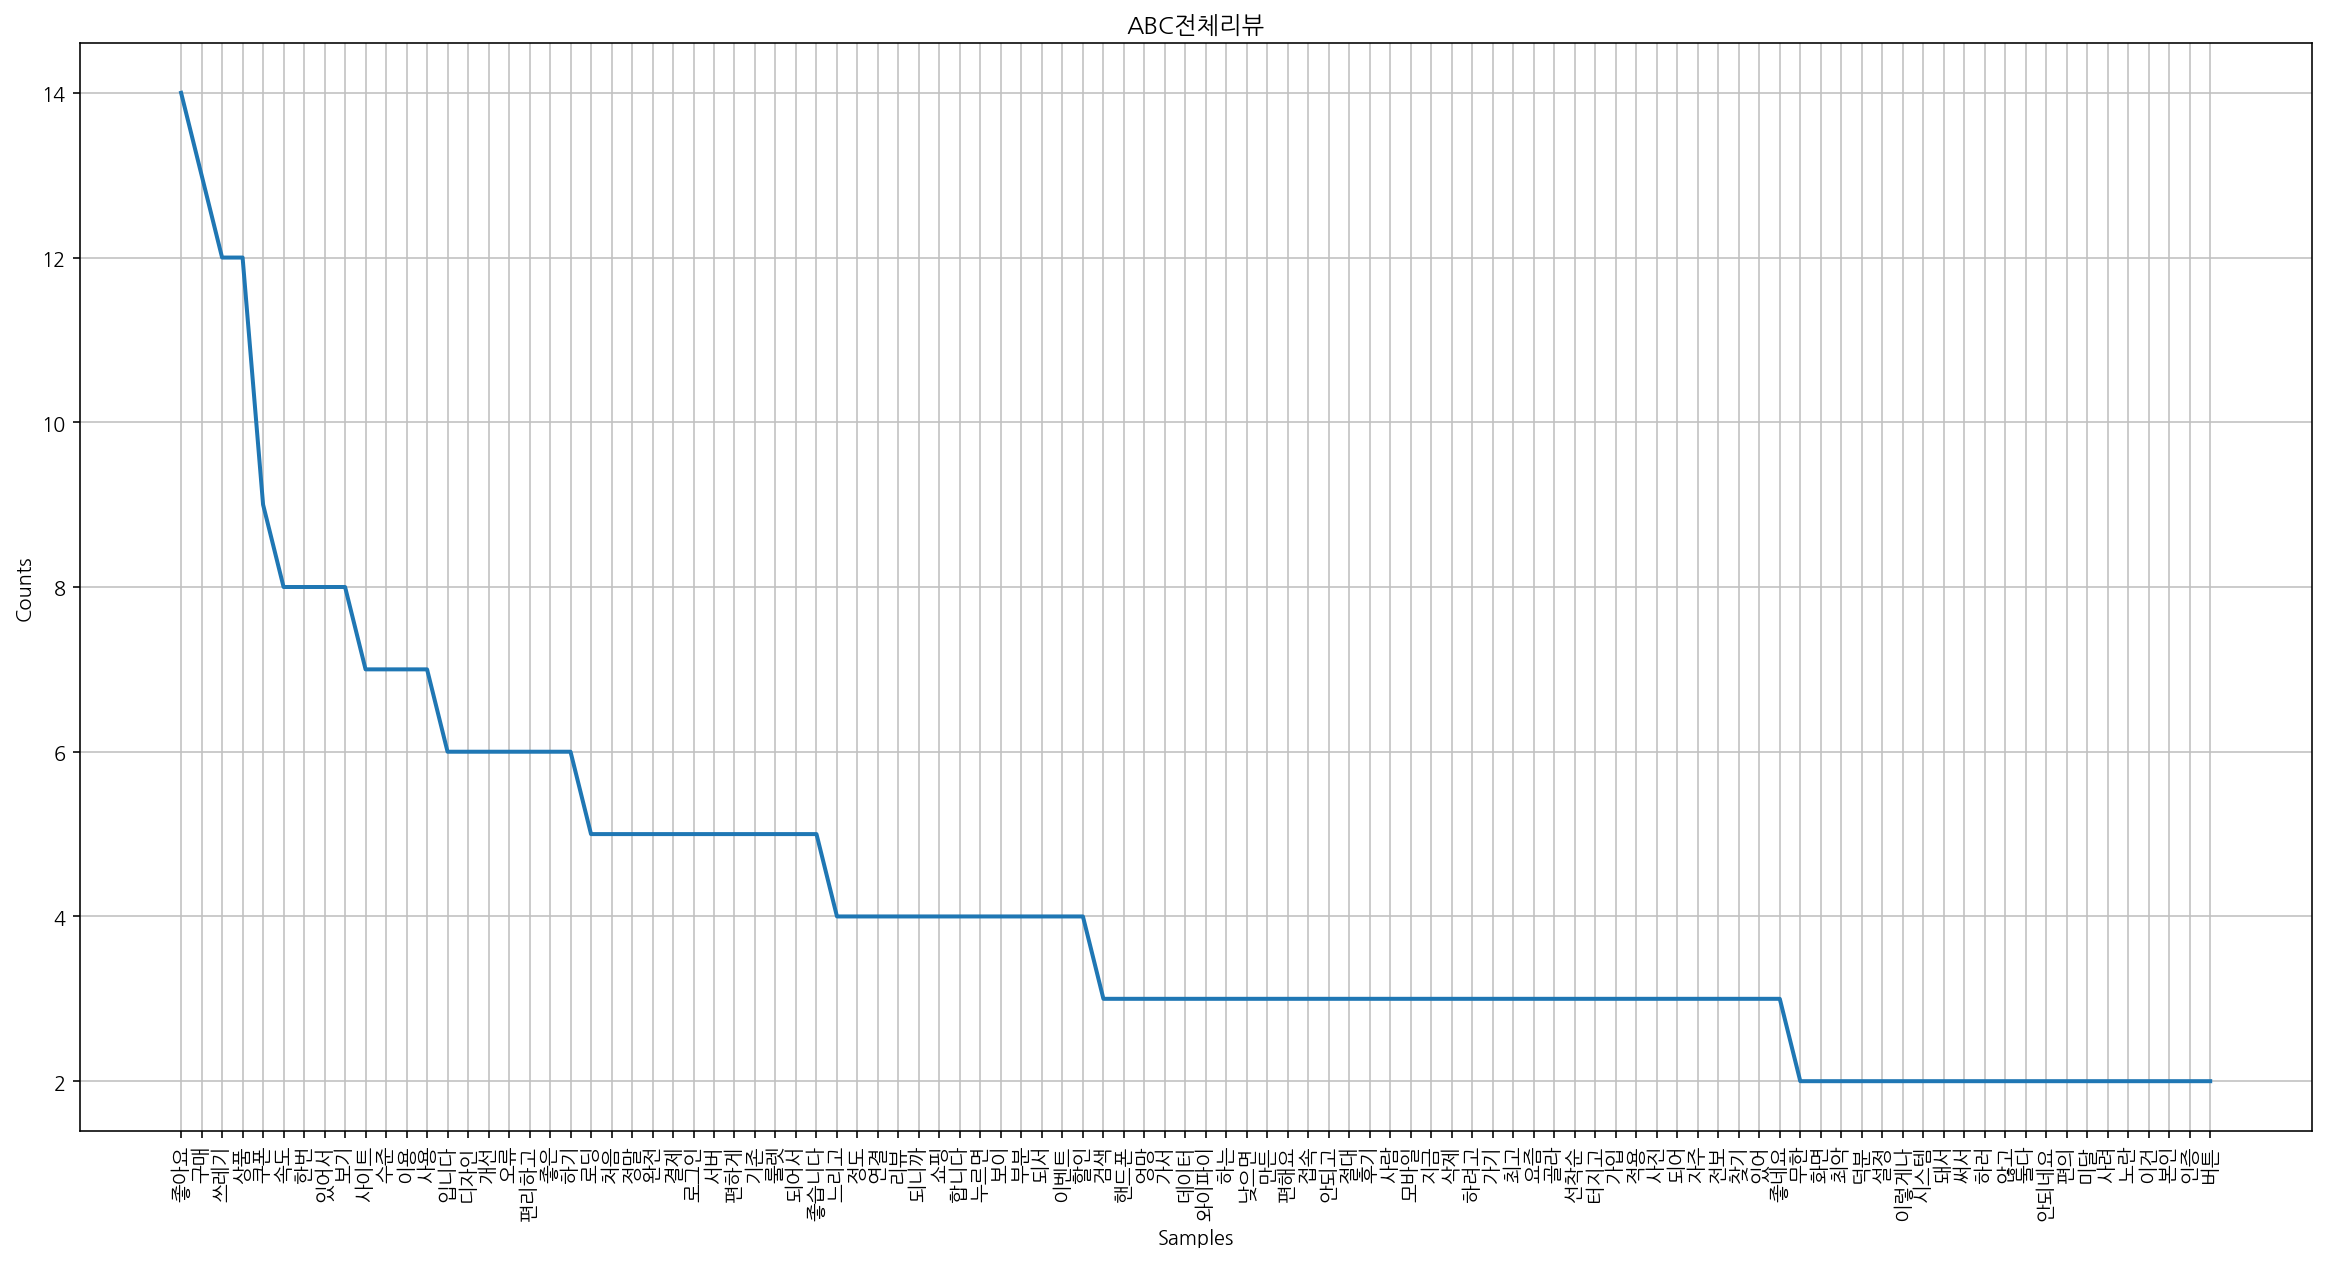

In [ ]:
kor = nltk.Text(title, name='단어 빈도수')
plt.figure(figsize=(20,10))
plt.title("ABC전체리뷰")
kor.plot(100)
plt.show()

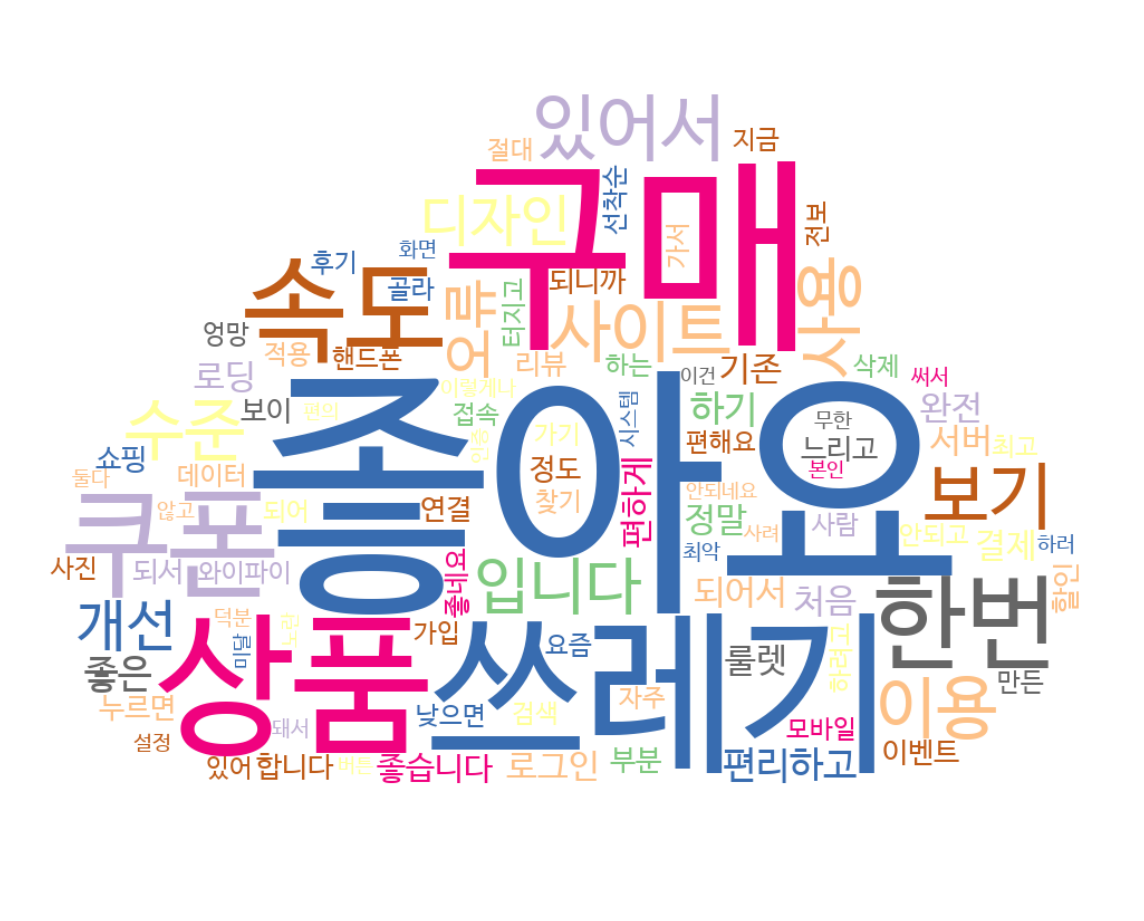

In [ ]:
text_cnt = Counter(kor) #워드클라우드를 만들기 전 불용어 제거한 단어들의 빈도수 저장
img_mask = np.array(Image.open("/content/drive/MyDrive/cloud.png")) #이미지 설정

wordcloud = WordCloud(font_path = fontpath, 
                      background_color='white',
                      colormap = "Accent_r", 
                      mask = img_mask, 
                      random_state = 20, 
                      max_words = 100).generate_from_frequencies(text_cnt)

plt.figure(figsize = (10, 10))
plt.imshow(wordcloud, interpolation = "bilinear")        
plt.axis("off")

plt.savefig("ABC.png")
plt.show()



> # LDA



In [ ]:
# 토픽 모델링 딕셔너리 생성
id2word = corpora.Dictionary(LL)
 
# 토픽모델링에 사용할 말뭉치 생성
texts = LL
 
# 용어-문서 빈도
corpus = [id2word.doc2bow(text) for text in texts]

print(id2word)
print(texts)
print(corpus)

Dictionary(757 unique tokens: ['검색', '안되네', '우편번호', '로딩', '무한']...)
[[], [], ['우편번호', '검색', '안되네'], ['아주', '병맛', '핸드폰', '웹페이지', '빨라', '무한', '로딩', '화면', '정지', '쓰겠냐'], [], ['살면서', '엉망', '진창', '처음', '본다'], ['사이트', '느리고', '느리면', '어쩌', '자는거', '드럽게', '하니까', '망하는거에요', '봐도', '토나올것', '딱지', '다른데', '가서', '사고말지', '드럽고', '괘씸해서'], ['수준', '높은지', '데이터', '와이파이', '커도', '인지', '하는', '수준', '만들었다'], ['낮으면', '안보', '일부러', '높게', '드령', '최악', '입니다', '덕분', '카드', '비번', '설정'], ['알림', '설정', '멈춤', '런가', '쓰레기', '같네'], ['구더기', '신기하네용', '정도', '수준', '있다니'], ['이렇게나', '시스템', '구린데', '이용', '만원', '쿠폰', '주겠다는', '낯짝', '걸어놓으신', '사용', '쿠폰', '누를', '앱스토어', '오지', '연결', '돼서', '연결', '리뷰', '드릴', '속도', '개느', '툭하면', '오류로', '대고', '쓰라고', '만든', '의심', '되니까', '어서', '써서', '속도', '맞춰가주세용', '개불', '편해요'], ['제일', '느린거', '쇼핑', '하러', '접속', '했다가', '구매', '의욕', '상실', '시키는', '답답한', '속도', '감탄', '합니다', '누르면', '실행', '안되고', '로딩', '걸리네요', '가서', '사든', '사야겠어요'], ['들어가지지도', '않고', '와이파이', '데이터', '둘다', '안되네요', '쓰레기', '놀랍다'], ['처음', '리뷰', '남깁니다', '정말', '처음', '입니다',

In [ ]:
#documents을 받아서 문서 단어 행렬 만들기
def build_doc_term_mat(documents): 
    
    id2word = corpora.Dictionary(documents) #id2word : 토픽 모델링 딕셔너리
    corpus = [id2word.doc2bow(document) for document in documents] #corpus : 용어-문서 빈도

    return corpus, id2word 
    
    
#단어를 입력하면 단어가 여러 토픽에 해당될 수 있는데 각 토픽에서 갖는 가중치를 표시
def print_term_topics(term, dictionary, model):
    word_id = dictionary.token2id[term]   #단어의 아이디 구함
    print(model.get_term_topics(word_id))  

# 문서에 대한 토픽가중치를 반복하면서 전체 문서에 대해서 표시
def print_doc_topics(model, corpus): 
    
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        print("Doc num: {}".format(doc_num))

        for topic_id, prob in topic_probs:
            print("\t{}\t{}".format(topic_id, prob))
        
        if doc_num == 2:  # 시간 관계상 2번 문서까지만 출력, "0번문서, 1번문서, 2번문서"에 대해서만 해당문서의 토픽가중치를 표시                                     
            break

        print("\n")  

#모델링 후 각 토픽별로 중요한 단어들을 표시
def print_topic_words(model) : 
    for topic_id in range(NUM_TOPICS): 
        topic_word_probs = model.show_topic(topic_id, TOPICS_W_NUM)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
        print("\n")

#LDA 시각화
def create_vis(model):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word, sort_topics=False)
    pyLDAvis.save_html(vis, RESULT_SAVE_LDAVIS)
    return vis

In [ ]:
corpus, id2word = build_doc_term_mat(LL)
print(id2word.token2id) #단어들의 id표시
print(corpus[2][:5]) #예시

{'검색': 0, '안되네': 1, '우편번호': 2, '로딩': 3, '무한': 4, '병맛': 5, '빨라': 6, '쓰겠냐': 7, '아주': 8, '웹페이지': 9, '정지': 10, '핸드폰': 11, '화면': 12, '본다': 13, '살면서': 14, '엉망': 15, '진창': 16, '처음': 17, '가서': 18, '괘씸해서': 19, '느리고': 20, '느리면': 21, '다른데': 22, '드럽게': 23, '드럽고': 24, '딱지': 25, '망하는거에요': 26, '봐도': 27, '사고말지': 28, '사이트': 29, '어쩌': 30, '자는거': 31, '토나올것': 32, '하니까': 33, '높은지': 34, '데이터': 35, '만들었다': 36, '수준': 37, '와이파이': 38, '인지': 39, '커도': 40, '하는': 41, '낮으면': 42, '높게': 43, '덕분': 44, '드령': 45, '비번': 46, '설정': 47, '안보': 48, '일부러': 49, '입니다': 50, '최악': 51, '카드': 52, '같네': 53, '런가': 54, '멈춤': 55, '쓰레기': 56, '알림': 57, '구더기': 58, '신기하네용': 59, '있다니': 60, '정도': 61, '개느': 62, '개불': 63, '걸어놓으신': 64, '구린데': 65, '낯짝': 66, '누를': 67, '대고': 68, '돼서': 69, '되니까': 70, '드릴': 71, '리뷰': 72, '만든': 73, '만원': 74, '맞춰가주세용': 75, '사용': 76, '속도': 77, '시스템': 78, '써서': 79, '쓰라고': 80, '앱스토어': 81, '어서': 82, '연결': 83, '오류로': 84, '오지': 85, '의심': 86, '이렇게나': 87, '이용': 88, '주겠다는': 89, '쿠폰': 90, '툭하면': 91, '편해요': 92, '감탄': 93, '걸리네요': 

In [ ]:
# Perplexity와 Coherence Score 을 판단
# Perplexity는 작을 수록 Coherence Score는 높을 수록 좋다.

TOPICS_W_NUM =5 #토픽 당 단어수는 5개
save_lda_model=0
UPDATE_EVERY = 1
CHUNKSIZE = 100
PASSES = 10

for i in range(1,30):
  NUM_TOPICS=i
 
  #해당 셀은 토픽모델링(LDA)에 대해 모델을 정의하는 셀
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                              num_topics=NUM_TOPICS, random_state=100, 
                                              update_every=UPDATE_EVERY, chunksize=CHUNKSIZE,
                                              passes=PASSES, alpha='auto', per_word_topics=True)

  doc_lda = lda_model[corpus]

  
  # Perplexity | Coherence Score
  coherence_model_lda = CoherenceModel(model=lda_model, texts=LL, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()

  print('NUM_TOPICS',NUM_TOPICS,'Perplexity: ', lda_model.log_perplexity(corpus),'Coherence: ', coherence_lda)



NUM_TOPICS 1 Perplexity:  -6.952734610490632 Coherence:  0.6042671806477938
NUM_TOPICS 2 Perplexity:  -7.087092802549402 Coherence:  0.48015448597749333
NUM_TOPICS 3 Perplexity:  -7.22980946412212 Coherence:  0.43508551251191885
NUM_TOPICS 4 Perplexity:  -7.266761700443008 Coherence:  0.48128890914583156
NUM_TOPICS 5 Perplexity:  -7.427865002055963 Coherence:  0.4680449715432496
NUM_TOPICS 6 Perplexity:  -7.445652862651306 Coherence:  0.44869133228574
NUM_TOPICS 7 Perplexity:  -7.485193931821145 Coherence:  0.4778703268075661
NUM_TOPICS 8 Perplexity:  -7.490715016267802 Coherence:  0.4373202282850851
NUM_TOPICS 9 Perplexity:  -7.572036385353197 Coherence:  0.4127339497528214
NUM_TOPICS 10 Perplexity:  -7.5845219545197065 Coherence:  0.41740168305638664
NUM_TOPICS 11 Perplexity:  -7.65093146154755 Coherence:  0.44358994880245056
NUM_TOPICS 12 Perplexity:  -7.637876261012596 Coherence:  0.4503731459938996
NUM_TOPICS 13 Perplexity:  -7.66207364269516 Coherence:  0.4117447756061138
NUM_TOP

KeyboardInterrupt: ignored

In [ ]:
print('토픽 기본 모델링을 실시 합니다. 해당 모델은 "lda_model" 변수로 입력됩니다.')
print(' ')

NUM_TOPICS = int(input('토픽의 개수를 입력해 주세요. ')) #8개
TOPICS_W_NUM = int(input('출력할 토픽별 단어의 개수를 입력해 주세요 ')) #10개
save_lda_model= int(input("선택한 토픽 모델을 저장하시겠습니까? \n0 저장  \n1 미저장  "))  #0 : 저장

UPDATE_EVERY = 1
CHUNKSIZE = 100
PASSES = 10

#lda 모델 정의
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                            num_topics=NUM_TOPICS, random_state=100, 
                                            update_every=UPDATE_EVERY, chunksize=CHUNKSIZE,
                                            passes=PASSES, alpha='auto', per_word_topics=True)

# 토픽 출력
pprint(lda_model.print_topics(num_words=TOPICS_W_NUM))
doc_lda = lda_model[corpus]

# 모델 저장 
if save_lda_model == 0:
    lda_model.save(LDA_MODEL_SAVE_NAME)

토픽 기본 모델링을 실시 합니다. 해당 모델은 "lda_model" 변수로 입력됩니다.
 
토픽의 개수를 입력해 주세요. 4
출력할 토픽별 단어의 개수를 입력해 주세요 5
선택한 토픽 모델을 저장하시겠습니까? 
0 저장  
1 미저장  0
[(0, '0.029*"디자인" + 0.019*"부분" + 0.016*"상품" + 0.013*"좋습니다" + 0.013*"처음"'),
 (1, '0.050*"좋아요" + 0.018*"쿠폰" + 0.018*"구매" + 0.014*"보기" + 0.013*"전보"'),
 (2, '0.015*"종류" + 0.014*"업뎃" + 0.014*"많아진듯" + 0.014*"신상" + 0.012*"쓰레기"'),
 (3, '0.016*"가는게" + 0.015*"거주" + 0.015*"멀어서" + 0.015*"아쉬운" + 0.015*"거리"')]


In [ ]:
55# 토픽별 키워드 조회
print_topic_words(lda_model)

Topic ID: 0
	디자인	0.029466966167092323
	부분	0.018893443048000336
	상품	0.016302768141031265
	좋습니다	0.012844927608966827
	처음	0.012837554328143597


Topic ID: 1
	좋아요	0.04970496520400047
	쿠폰	0.018479205667972565
	구매	0.017533138394355774
	보기	0.014275436289608479
	전보	0.013233190402388573


Topic ID: 2
	종류	0.015262629836797714
	업뎃	0.013723629526793957
	많아진듯	0.013723629526793957
	신상	0.013723629526793957
	쓰레기	0.011569367721676826


Topic ID: 3
	가는게	0.01609414629638195
	거주	0.014665134251117706
	멀어서	0.014665134251117706
	아쉬운	0.014665134251117706
	거리	0.014665134251117706






> # LDA 시각화



In [ ]:
"""
위의 셀에서 학습한 모델을 시각화 하여 HTML 파일로 저장하는 셀. 

"""

#lda_model or optimal_model
create_vis(lda_model)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.151915  0.016471       1        1  23.956184
1     -0.073447  0.095132       2        1  29.027232
2     -0.036249 -0.037983       3        1  25.119305
3     -0.042219 -0.073620       4        1  21.897278, topic_info=      Term       Freq      Total Category  logprob  loglift
487    좋아요  18.000000  18.000000  Default  30.0000  30.0000
118    디자인   8.000000   8.000000  Default  29.0000  29.0000
475     부분   6.000000   6.000000  Default  28.0000  28.0000
189    가는게   4.000000   4.000000  Default  27.0000  27.0000
90      쿠폰   7.000000   7.000000  Default  26.0000  26.0000
691     종류   4.000000   4.000000  Default  25.0000  25.0000
756    아쉬운   4.000000   4.000000  Default  24.0000  24.0000
755    멀어서   4.000000   4.000000  Default  23.0000  23.0000
754     거주   4.000000   4.000000  Default  22.0000  22.0000
753     거리   4.000000   4.000000  Default  21.0000  21.0000
724   많아진듯   4.000000   4.000000  Default  20.0000  20.0000
725     신상   4.000000   4.000000  Default  19.0000  19.0000
726     업뎃   4.000000   4.000000  Default  18.0000  18.0000
644     전보   4.000000   4.000000  Default  17.0000  17.0000
244     최고   4.000000   4.000000  Default  16.0000  16.0000
566     보기   8.000000   8.000000  Default  15.0000  15.0000
621   좋습니다   4.000000   4.000000  Default  14.0000  14.0000
17      처음   4.000000   4.000000  Default  13.0000  13.0000
224     가기   4.000000   4.000000  Default  12.0000  12.0000
642  깔끔해지고   4.000000   4.000000  Default  11.0000  11.0000
623  깔끔해져서   4.000000   4.000000  Default  10.0000  10.0000
95      구매   8.000000   8.000000  Default   9.0000   9.0000
243     목록   4.000000   4.000000  Default   8.0000   8.0000
655     있어   3.000000   3.000000  Default   7.0000   7.0000
56     쓰레기   5.000000   5.000000  Default   6.0000   6.0000
728    싶어요   4.000000   4.000000  Default   5.0000   5.0000
727   많이줘서   4.000000   4.000000  Default   4.0000   4.0000
752   있긴한데   4.000000   4.000000  Default   3.0000   3.0000
749   군더더기   4.000000   4.000000  Default   2.0000   2.0000
751    없는게   4.000000   4.000000  Default   1.0000   1.0000
118    디자인   8.047443   8.636584   Topic1  -3.5245   1.3583
621   좋습니다   3.507956   4.097202   Topic1  -4.3548   1.2737
17      처음   3.505943   4.098111   Topic1  -4.3554   1.2729
475     부분   5.159809   6.141507   Topic1  -3.9689   1.2548
655     있어   3.011298   3.607416   Topic1  -4.5075   1.2483
126     편의   2.770142   3.359281   Topic1  -4.5909   1.2361
172    바코드   2.770133   3.359285   Topic1  -4.5909   1.2361
696     되니   2.770020   3.359336   Topic1  -4.5910   1.2361
729   깔끔해요   2.524180   3.113319   Topic1  -4.6839   1.2192
730    되있고   2.524180   3.113319   Topic1  -4.6839   1.2192
740   깔끔하구   2.524120   3.113346   Topic1  -4.6839   1.2191
741     니당   2.524120   3.113346   Topic1  -4.6839   1.2191
742     매우   2.524120   3.113346   Topic1  -4.6839   1.2191
743     먼저   2.524120   3.113346   Topic1  -4.6839   1.2191
744    보는데   2.524120   3.113346   Topic1  -4.6839   1.2191
745     볼때   2.524120   3.113346   Topic1  -4.6839   1.2191
746  봐야겠지만   2.524120   3.113346   Topic1  -4.6839   1.2191
747   불편함이   2.524120   3.113346   Topic1  -4.6839   1.2191
748     흰색   2.524120   3.113346   Topic1  -4.6839   1.2191
734    깔끔한   2.524050   3.113377   Topic1  -4.6840   1.2191
735    들어요   2.524050   3.113377   Topic1  -4.6840   1.2191
736     마음   2.524050   3.113377   Topic1  -4.6840   1.2191
737  모르겠지만   2.524050   3.113377   Topic1  -4.6840   1.2191
738     쓴지   2.524050   3.113377   Topic1  -4.6840   1.2191
739     전체   2.524050   3.113377   Topic1  -4.6840   1.2191
717   나왔으면   2.523851   3.113468   Topic1  -4.6841   1.2190
718     번로   2.523851   3.113468   Topic1  -4.6841   1.2190
719     스벅   2.523851   3.113468   Topic1  -4.6841   1.2190
720     인안   2.523851   3.113468   Topic1  -4.6841   1.2190
721   좋겠어요   2.523851   3.113468 

### Topic 01
	* 디자인	0.029466966167092323
	* 부분	0.018893443048000336
	* 상품	0.016302768141031265
	* 좋습니다	0.012844927608966827
	* 처음	0.012837554328143597

- 보기, 좋습니다,디자인 

    기존 앱보다 디자인도 심플하고.   
    디자인도편하게.   
    깔끔한 디자인.   
    디자인과 편의성을 먼저 보는데 흰색이라 보기 매우 깔끔하.   
    통합되어서 상품을 찾기 쉬워진거.   
    어플통합.   
 
   
### Topic 2
	* 좋아요	0.04970496520400047
	* 쿠폰	0.018479205667972565
	* 구매	0.017533138394355774
	* 보기	0.014275436289608479
	* 전보	0.013233190402388573

- 좋아요,쿠폰, 전보다 ,보기
    전보다 보기 편해져서 좋아요.    
    할인쿠폰도주고 룰렛돌려서 커피받고 좋아요.     
    깔끔해져서 좋다.     
    통합멤버십 좋아요.      
    재고를 볼수있어서 좋아요.       
    통합되어서 좋아요.      
    전에 노란 abc마트 앱도 완전 쓰레기고... 그나마 이건 까니까 구매로 넘어가긴하네요ㅠㅠ 노란 abc는 진짜 쓰레기였어요!!  
   
### Topic 3
	* 종류	0.015262629836797714
	* 업뎃	0.013723629526793957
	* 많아진듯	0.013723629526793957
	* 신상	0.013723629526793957
	* 쓰레기	0.011569367721676826
- 종류 없뎃 많아진듯 신상
    종류 다양해짐           
    신상을 바로볼수있어서 좋아요           
    종류도 많아진듯           

#### 그럼에도 불구하고......
    * 쓰레기
    오! 쓰레기 발싸!,"들어가지지도 않고 와이파이 데이터 둘다 안되네요!
    이런 쓰레기!! 와 놀랍다!!"
    살면서 이 따위로 엉망진창인 앱은 처음
    이런앱 진짜 느리고 쓰레기다
    우와 이런 앱 처음 봐요,진짜 구더기 그 자체! 신기하네용 2022년에 이 정도 수준의 앱이 있다니
    처음런칭했을때나 지금이나 변함없이 거지같이 느린 앱입니다.^^
